In [3]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [31]:
def load_dataframe(path):
    classes = os.listdir(path)
    df = pd.DataFrame()
    
    for cls in classes:
        cls_path = os.path.join(path, cls)
        
        if not os.path.isdir(cls_path):
            continue
            
        for file in os.listdir(cls_path):
            image_path = os.path.join(path, cls, file)
            
            if os.path.isfile(image_path):
                image = Image.open(image_path)
                image = np.asarray(image, dtype=np.double)
                image_norm = np.linalg.norm(image)
                if image_norm == 0:
                    continue
                image /= image_norm
                df = df.append(pd.Series({'emotion': cls, 'image': image}), ignore_index=True)
    
    return df

In [32]:
df_train = load_dataframe('data/train')
df_test = load_dataframe('data/test')

In [33]:
df_train.shape

(28698, 2)

In [34]:
df_train['emotion'].value_counts()

happy       7214
neutral     4964
sad         4829
fear        4097
angry       3988
surprise    3170
disgust      436
Name: emotion, dtype: int64

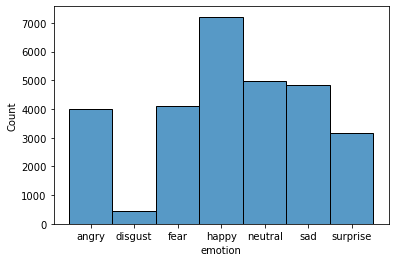

In [35]:
sns.histplot(df_train['emotion']);

In [36]:
df_train.head()

,emotion,image
0,angry,"[[0.008852438274353128, 0.005665560495586001, ..."
1,angry,"[[0.005020191736857478, 0.004154641437399292, ..."
2,angry,"[[0.02534378514188006, 0.02256414419083515, 0...."
3,angry,"[[0.026124269527077703, 0.0266195163427569, 0...."
4,angry,"[[0.006619074423807762, 0.006802937602246866, ..."


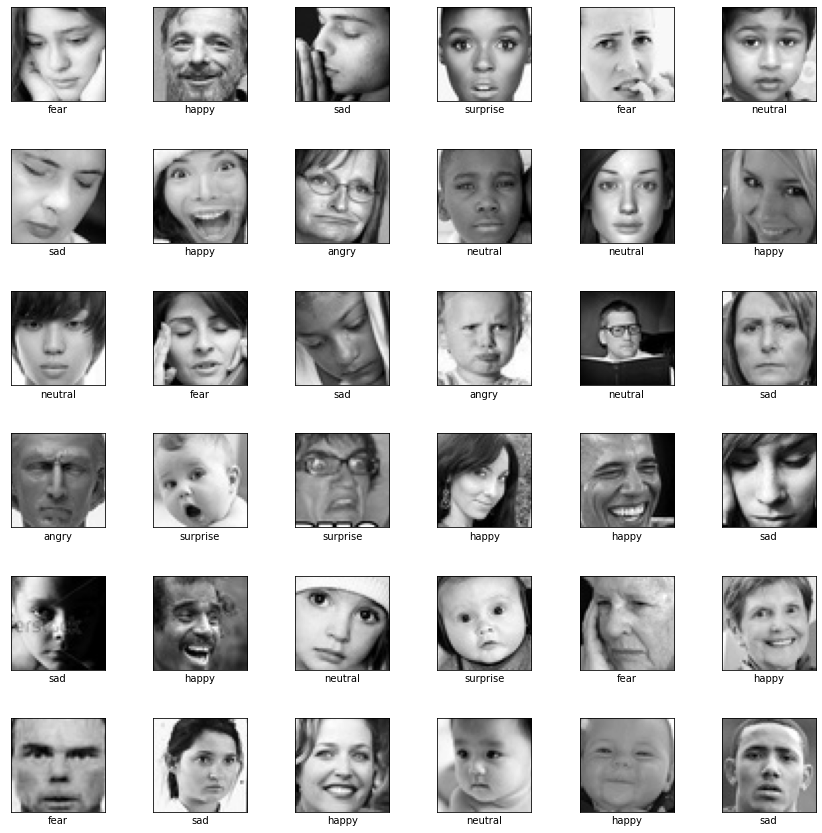

In [39]:
def plot_as_images(rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2,rows*2))
    fig.tight_layout()
    
    for i in range(rows):
        for j in range(cols):
            index = np.random.choice(np.arange(len(df_train)))
            axes[i,j].imshow(df_train.image[index], cmap="gray")
            axes[i,j].set_xlabel(df_train.emotion[index])
            axes[i,j].get_yaxis().set_visible(False)
            axes[i,j].set_xticks([])

plot_as_images(6, 6)

In [93]:
nclasses = df_train.emotion.nunique()
img_size = df_train.image[0].shape[0]

In [94]:
def preprocess_dataframe(df):
    emotions = df.emotion.unique()
    emotions_map = {emotion: i for i, emotion in enumerate(emotions)}
    
    X = np.stack(df.image.apply(lambda img: img.reshape(img_size * img_size, order='F')).values)
    y = df.emotion.apply(lambda emo: emotions_map[emo])
    
    return X, y

In [85]:
X_train, y_train = preprocess_dataframe(df_train)
X_train.shape, y_train.shape

((28698, 2304), (28698,))

In [86]:
from sklearn.linear_model import LogisticRegression

In [21]:
from sklearn.datasets import fetch_openml

In [22]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [26]:
X.shape

(70000, 784)

In [88]:
clf = LogisticRegression(tol=0.1, solver='saga').fit(X_train, y_train)

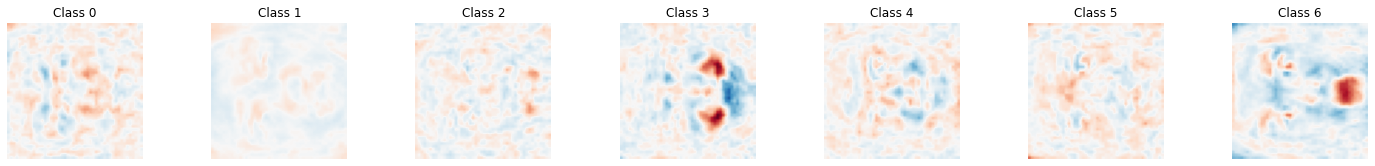

In [95]:
scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 2.5));

for i in range(nclasses):
    p = plt.subplot(1, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(img_size, img_size),
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.axis('off')
    p = plt.title('Class %i' % i);